Kết nối Colab với Google Drive để lấy dữ liệu

Cài đặt thư viện Gensim cho việc train model Word2Vec

In [ ]:
!pip install gensim

Import các thư viện cần thiết

In [ ]:
import os
import re
import pandas as pd
import string
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Load tập dữ liệu từ thư mục trong Google Drive

In [ ]:
# Load data
def load_data(csv_file):
    return pd.read_csv(csv_file, encoding="latin")

train_data = load_data("Corona_NLP_train.csv").iloc[:2000]

train_data = train_data["OriginalTweet"].to_list()
# train_data = "\n".join(train_data)

stopwords_list=stopwords.words('english')

def clean_data(w):
    w = w.lower()
    w = re.sub(r"'s\b","", w)
    w = re.sub("[^a-zA-Z]", " ", w)
    words = w.split()
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words)


def get_inp(list_sent):
    sent=list(map(clean_data, list_sent))
    sent=list(map(lambda x: x.split(" "), sent))
    return sent

# print(train_data[:1000])
inp_data=get_inp(train_data)
print(inp_data[:5])

[['menyrbie', 'phil', 'gahan', 'chrisitv', 'https', 'ifz', 'fan', 'https', 'ghgfzcc', 'https', 'nlzdxno'], ['advice', 'talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'phone', 'numbers', 'neighbours', 'schools', 'employer', 'chemist', 'set', 'online', 'shopping', 'accounts', 'poss', 'adequate', 'supplies', 'regular', 'meds', 'order'], ['coronavirus', 'australia', 'woolworths', 'give', 'elderly', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'covid', 'outbreak', 'https', 'binca'], ['food', 'stock', 'one', 'empty', 'please', 'panic', 'enough', 'food', 'everyone', 'take', 'need', 'stay', 'calm', 'stay', 'safe', 'covid', 'france', 'covid', 'covid', 'coronavirus', 'confinement', 'confinementotal', 'confinementgeneral', 'https', 'zrlg'], ['ready', 'supermarket', 'covid', 'outbreak', 'paranoid', 'food', 'stock', 'litteraly', 'empty', 'coronavirus', 'serious', 'thing', 'please', 'panic', 'causes', 'shortage', 'coronavirusfrance', 'restezchezv

Train model Word2Vec. Trong quá trình train, có bạn có thể chỉnh sử dụng GPU của Colab để đẩy nhanh tiến độ bằng cách vào Rumtime => Change Runtime Type và chọn GPU

In [ ]:
# Skipgram model
model = Word2Vec(inp_data, min_count = 1, size = 256, window = 5, sg = 1)
model.build_vocab(inp_data, update=True)

model.train(inp_data, total_examples=model.corpus_count, epochs=1000)
model.wv.save('word2vec_skipgram.bin')


# CBOW model
model = Word2Vec(inp_data, min_count = 1, size = 256, window = 5, sg = 0)
model.build_vocab(inp_data, update=True)

model.train(inp_data, total_examples=model.corpus_count, epochs=1000)
model.wv.save('word2vec_CBOW.bin')


Sau khi có model. Ta tiến hành load mô hình

In [ ]:
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from scipy.spatial import distance
path = 'word2vec_CBOW.bin'
model = gensim.models.KeyedVectors.load(path)

In [ ]:
with open("vocab.txt", "w", encoding="utf-8") as f:
    for x in model.wv.vocab.keys():
        f.write(x + "\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Test kết quả

In [ ]:
model.most_similar(positive=['covid'], topn=10)

[('food', 0.6159958839416504),
 ('people', 0.5343393087387085),
 ('https', 0.5051104426383972),
 ('grocery', 0.5047034025192261),
 ('coronavirus', 0.4889095425605774),
 ('store', 0.483211874961853),
 ('online', 0.4404439628124237),
 ('panic', 0.43203458189964294),
 ('need', 0.4167065918445587),
 ('supermarket', 0.41414374113082886)]

In [ ]:
word_0 = "virus"
word_1 = "vaccines"
word_2 = "playing"

word_0_eb = model[word_0]
word_1_eb = model[word_1]
word_2_eb = model[word_2]

dst_0_1 = distance.euclidean(word_0_eb, word_1_eb)
dst_1_2 = distance.euclidean(word_1_eb, word_2_eb)
dst_2_0 = distance.euclidean(word_2_eb, word_0_eb)

print("OUTPUT DISTANCE")
print("0 vs 1: ", dst_0_1)
print("1 vs 2: ", dst_1_2)
print("2 vs 0: ", dst_2_0)

OUTPUT DISTANCE
0 vs 1:  36.033241271972656
1 vs 2:  18.535076141357422
2 vs 0:  38.76089096069336


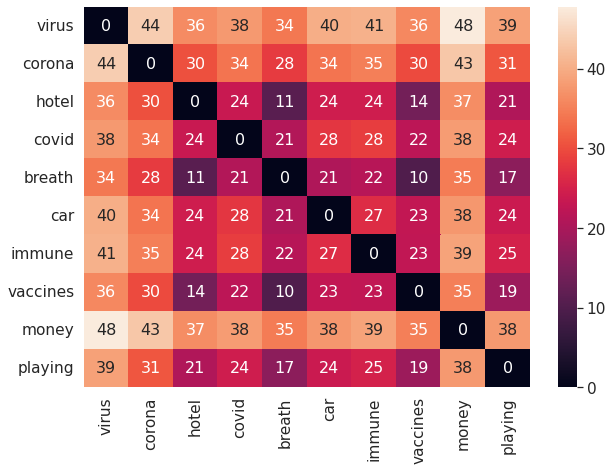

In [ ]:
from scipy.spatial import distance_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

list_words = ["virus", "corona", "hotel", "covid", "breath", "car", "immune", "vaccines", "money", "playing"]
list_word_embs = list(map(lambda x: model[x], list_words))

dm = distance_matrix(list_word_embs, list_word_embs, p=2)

df_dm = pd.DataFrame(dm, list_words, list_words)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_dm, annot=True, annot_kws={"size": 16}) # font size

plt.show()
